In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
folder_names = os.listdir('data')

In [3]:
colnames = ['id', 'posnum', 'seglen_hor', 'seglen_ver', 'segdist_hor', 'segdist_ver', 'crossdeg', 'segdeg_hor', 'segdeg_ver', 'dist_hor', 'dist_ver']

In [4]:
def collect_data(folder_names):
    data = []
    labels = []
    metadata = []  # img_id, posnum
    for img_id, name in enumerate(folder_names):
        if not os.path.exists('data/' + name + '/ml_data1.csv'): continue
        d = pd.read_csv('data/' + name + '/ml_data1.csv', names=colnames)
        a = pd.read_csv('data/' + name + '/ans.txt', header=None).values.ravel()
        # no answer => "-1"
        assert len(a) == 4, f"len(a) = {len(a)} (!= 4)"
        for row in d.values:
            label = 1 if row[0] in a else 0
            labels.append(label)
            metadata.append((img_id, row[1]))
            data.append(row[2:])
            
            for i in range(4):    # for debug
                if row[0] == a[i]:
                    assert row[1] == i, "corrupted in posnum"
    return np.array(data), np.array(labels), np.array(metadata)

In [5]:
data, labels, metadata = collect_data(folder_names)

In [6]:
print(len(labels), sum(labels))

17454 221


In [7]:
feature_dict = {colnames[i+2]: i for i in range(len(colnames)-2)}
feature_dict

{'seglen_hor': 0,
 'seglen_ver': 1,
 'segdist_hor': 2,
 'segdist_ver': 3,
 'crossdeg': 4,
 'segdeg_hor': 5,
 'segdeg_ver': 6,
 'dist_hor': 7,
 'dist_ver': 8}

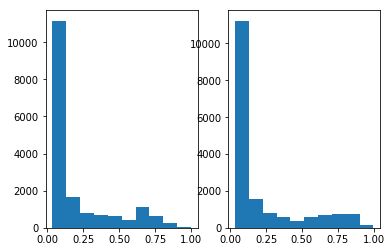

In [8]:
plt.subplot(1, 2, 1)
plt.hist(data[:, feature_dict['seglen_hor']])
plt.subplot(1, 2, 2)
plt.hist(data[:, feature_dict['seglen_ver']])
plt.show()

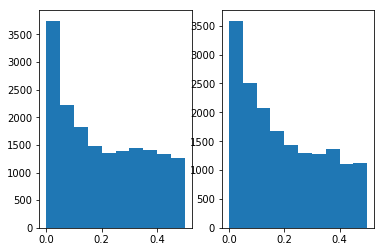

In [9]:
plt.subplot(1, 2, 1)
plt.hist(data[:, feature_dict['segdist_hor']])
plt.subplot(1, 2, 2)
plt.hist(data[:, feature_dict['segdist_ver']])
plt.show()

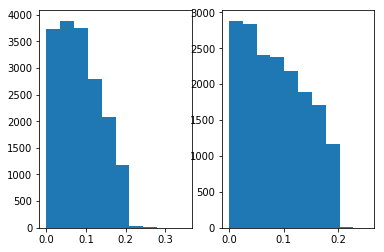

In [10]:
plt.subplot(1, 2, 1)
plt.hist(data[:, feature_dict['dist_hor']])
plt.subplot(1, 2, 2)
plt.hist(data[:, feature_dict['dist_ver']])
plt.show()

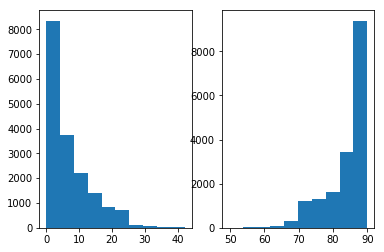

In [12]:
plt.subplot(1, 2, 1)
plt.hist(data[:, feature_dict['segdeg_hor']] * 180 / np.pi)
plt.subplot(1, 2, 2)
plt.hist(data[:, feature_dict['segdeg_ver']] * 180 / np.pi)
plt.show()

In [24]:
import random
img_indice = range(len(folder_names))
img_indice_train = random.sample(img_indice, int(len(img_indice) * 0.7))
data_train = []
data_test = []
labels_train = []
labels_test = []
metadata_train = []
metadata_test = []
# split data (don't split image)
for i in range(len(data)):
    if metadata[i][0] in img_indice_train:
        data_train.append(data[i])
        labels_train.append(labels[i])
        metadata_train.append(metadata[i])
    else:
        data_test.append(data[i])
        labels_test.append(labels[i])
        metadata_test.append(metadata[i])
data_train = np.array(data_train)
data_test = np.array(data_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
metadata_train = np.array(metadata_train)
metadata_test = np.array(metadata_test)

In [25]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
data_train = stdsc.fit_transform(data_train)
data_test = stdsc.transform(data_test)

In [26]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_train)
transformed_train = pca.fit_transform(data_train)
transformed_test = pca.transform(data_test)

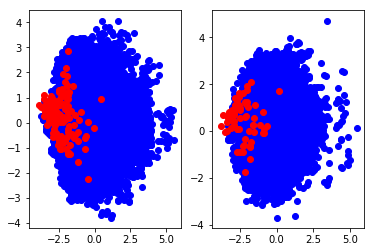

In [27]:
plt.subplot(1, 2, 1)
plt.scatter(transformed_train[labels_train==0][:,0], transformed_train[labels_train==0][:,1], c='blue')
plt.scatter(transformed_train[labels_train==1][:,0], transformed_train[labels_train==1][:,1], c='red')
plt.subplot(1, 2, 2)
plt.scatter(transformed_test[labels_test==0][:,0], transformed_test[labels_test==0][:,1], c='blue')
plt.scatter(transformed_test[labels_test==1][:,0], transformed_test[labels_test==1][:,1], c='red')
plt.show()

In [28]:
print(len(img_indice), len(img_indice_train))

56 39


In [29]:
def rank_accuracy(true_labels, pred_vals, metadata, n_tol=3):
    positive_vals = pred_vals
    if pred_vals.ndim == 2:  # case of predict_proba
        positive_vals = pred_vals[:, 1]
    indice = np.argsort(positive_vals)[::-1]  # descending order
    err_count = {}
    errors = []
    corrects = []
    for idx in indice:
        md = tuple(metadata[idx])
        if not md in err_count:
            err_count[md] = 0
        if md in corrects or md in errors:  # already decided
            continue
        if true_labels[idx] == 1:  # correct classification
            corrects.append(md)
        else:
            err_count[md] += 1  # wrong classfication
            if err_count[md] >= n_tol:
                errors.append(md)
    
    return len(corrects) / len(err_count)

## simple SVM

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
svm = SVC(gamma='auto')
svm.fit(data_train, labels_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
print(svm.score(data_train, labels_train))
print(svm.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm.predict(data_train)))
print(confusion_matrix(labels_test, svm.predict(data_test)))
print(rank_accuracy(labels_train, svm.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm.decision_function(data_test), metadata_test, n_tol=2))

0.9913079470198676
0.9893373952779894
[[11932    16]
 [   89    43]]
[[5176   11]
 [  45   20]]
0.8636363636363636
0.6764705882352942


## SVM with random over sampling

In [167]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(0.5)
data_ros, labels_ros = ros.fit_resample(data_train, labels_train)
print(sorted(Counter(labels_ros).items()))

svm_ros = SVC(gamma='auto')
svm_ros.fit(data_ros, labels_ros)

[(0, 10647), (1, 5323)]


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [168]:
print(svm_ros.score(data_train, labels_train))
print(svm_ros.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_ros.predict(data_train)))
print(confusion_matrix(labels_test, svm_ros.predict(data_test)))
print(rank_accuracy(labels_train, svm_ros.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_ros.decision_function(data_test), metadata_test, n_tol=2))

0.9677090099285516
0.9492600422832981
[[10300   347]
 [    1   129]]
[[4434  237]
 [   3   56]]
0.9393939393939394
0.8333333333333334


## SVM with SMOTE

In [171]:
from imblearn.over_sampling import SMOTE
data_smote, labels_smote = SMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_smote == 0), sum(labels_smote == 1))

svm_smote = SVC(gamma='auto')
svm_smote.fit(data_smote, labels_smote)

10647 5323


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [172]:
print(svm_smote.score(data_train, labels_train))
print(svm_smote.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_smote.predict(data_train)))
print(confusion_matrix(labels_test, svm_smote.predict(data_test)))
print(rank_accuracy(labels_train, svm_smote.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_smote.decision_function(data_test), metadata_test, n_tol=2))

0.9709566669759674
0.9575052854122622
[[10337   310]
 [    3   127]]
[[4473  198]
 [   3   56]]
0.9242424242424242
0.8333333333333334


## SVM with ADASYN

In [173]:
from imblearn.over_sampling import ADASYN
data_ada, labels_ada = ADASYN(0.5).fit_resample(data_train, labels_train)
print(sum(labels_ada == 0), sum(labels_ada == 1))

svm_ada = SVC(gamma='auto')
svm_ada.fit(data_ada, labels_ada)

10647 5362


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [174]:
print(svm_ada.score(data_train, labels_train))
print(svm_ada.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_ada.predict(data_train)))
print(confusion_matrix(labels_test, svm_ada.predict(data_test)))
print(rank_accuracy(labels_train, svm_ada.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_ada.decision_function(data_test), metadata_test, n_tol=2))

0.9667811079150042
0.9507399577167019
[[10290   357]
 [    1   129]]
[[4442  229]
 [   4   55]]
0.9242424242424242
0.7833333333333333


## SVM with BorderlineSMOTE

In [230]:
from imblearn.over_sampling import BorderlineSMOTE
data_bsmote, labels_bsmote = BorderlineSMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_bsmote == 0), sum(labels_bsmote == 1))

svm_bsmote = SVC(gamma='auto')
svm_bsmote.fit(data_bsmote, labels_bsmote)

9985 4992


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [231]:
print(svm_bsmote.score(data_train, labels_train))
print(svm_bsmote.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_bsmote.predict(data_train)))
print(confusion_matrix(labels_test, svm_bsmote.predict(data_test)))
print(rank_accuracy(labels_train, svm_bsmote.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_bsmote.decision_function(data_test), metadata_test, n_tol=2))

0.9798319327731092
0.9799703264094956
[[9798  187]
 [  17  113]]
[[5235   98]
 [  10   49]]
0.8939393939393939
0.85


## SVM with SVMSMOTE

In [179]:
from imblearn.over_sampling import SVMSMOTE
data_svm, labels_svm = SVMSMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_svm == 0), sum(labels_svm == 1))

svm_ss = SVC(gamma='auto')
svm_ss.fit(data_svm, labels_svm)

10647 5323


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [180]:
print(svm_ss.score(data_train, labels_train))
print(svm_ss.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_ss.predict(data_train)))
print(confusion_matrix(labels_test, svm_ss.predict(data_test)))
print(rank_accuracy(labels_train, svm_ss.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_ss.decision_function(data_test), metadata_test, n_tol=2))

0.9828338127493736
0.9710359408033826
[[10479   168]
 [   17   113]]
[[4541  130]
 [   7   52]]
0.8560606060606061
0.8666666666666667


## SVM with ClusterCentroids (k-means)

In [181]:
from imblearn.under_sampling import ClusterCentroids
data_cc, labels_cc = ClusterCentroids(0.5).fit_resample(data_train, labels_train)
print(sum(labels_cc == 0), sum(labels_cc == 1))

svm_cc = SVC(gamma='auto')
svm_cc.fit(data_cc, labels_cc)

260 130


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [182]:
print(svm_cc.score(data_train, labels_train))
print(svm_cc.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_cc.predict(data_train)))
print(confusion_matrix(labels_test, svm_cc.predict(data_test)))
print(rank_accuracy(labels_train, svm_cc.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_cc.decision_function(data_test), metadata_test, n_tol=2))

0.94358355757632
0.9298097251585624
[[10046   601]
 [    7   123]]
[[4341  330]
 [   2   57]]
0.8939393939393939
0.7833333333333333


## SVM with RandomUnderSampler

In [183]:
from imblearn.under_sampling import RandomUnderSampler
data_rus, labels_rus = RandomUnderSampler(0.5, replacement=True).fit_resample(data_train, labels_train)
print(sum(labels_rus == 0), sum(labels_rus == 1))

svm_rus = SVC(gamma='auto')
svm_rus.fit(data_rus, labels_rus)

260 130


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [184]:
print(svm_rus.score(data_train, labels_train))
print(svm_rus.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_rus.predict(data_train)))
print(confusion_matrix(labels_test, svm_rus.predict(data_test)))
print(rank_accuracy(labels_train, svm_rus.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_rus.decision_function(data_test), metadata_test, n_tol=2))

0.9403359005289041
0.9255813953488372
[[10010   637]
 [    6   124]]
[[4321  350]
 [   2   57]]
0.8636363636363636
0.7666666666666667


## SVM with SMOTETomek

In [200]:
from imblearn.combine import SMOTETomek
data_st, labels_st = SMOTETomek(0.5).fit_resample(data_train, labels_train)
print(sum(labels_st == 0), sum(labels_st == 1))

svm_st = SVC(gamma='auto')
svm_st.fit(data_st, labels_st)

10647 5323


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [201]:
sum(labels_train == 0)

10647

In [202]:
print(svm_st.score(data_train, labels_train))
print(svm_st.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_st.predict(data_train)))
print(confusion_matrix(labels_test, svm_st.predict(data_test)))
print(rank_accuracy(labels_train, svm_st.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_st.decision_function(data_test), metadata_test, n_tol=2))

0.9702143453651294
0.9562367864693446
[[10329   318]
 [    3   127]]
[[4468  203]
 [   4   55]]
0.9318181818181818
0.8166666666666667


## SVM with SMOTEEN

In [232]:
from imblearn.combine import SMOTEENN
data_stee, labels_stee = SMOTEENN(0.5).fit_resample(data_train, labels_train)
print(sum(labels_stee == 0), sum(labels_stee == 1))

svm_stee = SVC(gamma='auto')
svm_stee.fit(data_stee, labels_stee)

9660 4974


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [233]:
print(svm_stee.score(data_train, labels_train))
print(svm_stee.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_stee.predict(data_train)))
print(confusion_matrix(labels_test, svm_stee.predict(data_test)))
print(rank_accuracy(labels_train, svm_stee.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_stee.decision_function(data_test), metadata_test, n_tol=2))

0.966584280771132
0.9643916913946587
[[9649  336]
 [   2  128]]
[[5150  183]
 [   9   50]]
0.9015151515151515
0.8


## RandomForest with BoarderlineSmote

In [30]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE
data_bsmote, labels_bsmote = BorderlineSMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_bsmote == 0), sum(labels_bsmote == 1))

forest_bs = RandomForestClassifier(n_estimators=100)
forest_bs.fit(data_bsmote, labels_bsmote)

11948 5974


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
print(forest_bs.score(data_train, labels_train))
print(forest_bs.score(data_test, labels_test))
print(confusion_matrix(labels_train, forest_bs.predict(data_train)))
print(confusion_matrix(labels_test, forest_bs.predict(data_test)))
print(rank_accuracy(labels_train, forest_bs.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, forest_bs.predict_proba(data_test), metadata_test, n_tol=2))

1.0
0.9874333587204874
[[11948     0]
 [    0   132]]
[[5149   38]
 [  28   37]]
1.0
0.8382352941176471


In [220]:
from sklearn.model_selection import GridSearchCV
forest_params = {
    'max_features': [1, 'auto', None],
    'max_depth': [1, 5, None],
    'min_samples_leaf': [1, 2, 4]
}
gs_forest = GridSearchCV(RandomForestClassifier(n_estimators=100), forest_params, cv=5)
gs_forest.fit(data_bsmote, labels_bsmote)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [1, 'auto', None], 'max_depth': [1, 5, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [221]:
print(gs_forest.best_params_)

{'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1}


In [225]:
forest = gs_forest.best_estimator_
print(forest.score(data_train, labels_train))
print(forest.score(data_test, labels_test))
print(confusion_matrix(labels_train, forest.predict(data_train)))
print(confusion_matrix(labels_test, forest.predict(data_test)))
print(rank_accuracy(labels_train, forest.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, forest.predict_proba(data_test), metadata_test, n_tol=2))

1.0
0.9845665961945032
[[10647     0]
 [    0   130]]
[[4626   45]
 [  28   31]]
0.9848484848484849
0.8333333333333334


## Blanced Bagging classifier

In [262]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                 sampling_strategy='auto',
                                 replacement=False,
                                 n_estimators=100)
bbc.fit(data_train, labels_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
             random_state=None, ratio=None, replacement=False,
             sampling_strategy='auto', verbose=0, warm_start=False)

In [263]:
print(bbc.score(data_train, labels_train))
print(bbc.score(data_test, labels_test))
print(confusion_matrix(labels_train, bbc.predict(data_train)))
print(confusion_matrix(labels_test, bbc.predict(data_test)))
print(rank_accuracy(labels_train, bbc.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, bbc.predict_proba(data_test), metadata_test, n_tol=2))

0.955116164112704
0.9541913946587537
[[9531  454]
 [   0  130]]
[[5087  246]
 [   1   58]]
0.946969696969697
0.8666666666666667


## Balanced RandomForest Classifier

In [52]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100)
brf.fit(data_train, labels_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [53]:
print(brf.score(data_train, labels_train))
print(brf.score(data_test, labels_test))
print(confusion_matrix(labels_train, brf.predict(data_train)))
print(confusion_matrix(labels_test, brf.predict(data_test)))
print(rank_accuracy(labels_train, brf.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, brf.predict_proba(data_test), metadata_test, n_tol=2))

0.9576158940397351
0.9554455445544554
[[11438   510]
 [    2   130]]
[[4956  231]
 [   3   62]]
0.9621212121212122
0.8676470588235294


In [272]:
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(n_estimators=100)
rusboost.fit(data_train, labels_train)

RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None,
          replacement=False, sampling_strategy='auto')

In [273]:
print(rusboost.score(data_train, labels_train))
print(rusboost.score(data_test, labels_test))
print(confusion_matrix(labels_train, rusboost.predict(data_train)))
print(confusion_matrix(labels_test, rusboost.predict(data_test)))
print(rank_accuracy(labels_train, rusboost.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, rusboost.predict_proba(data_test), metadata_test, n_tol=2))

0.9894216510133466
0.9820103857566765
[[9878  107]
 [   0  130]]
[[5254   79]
 [  18   41]]
0.9848484848484849
0.7666666666666667


In [274]:
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100)
eec.fit(data_train, labels_train)

EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=1,
            random_state=None, replacement=False, sampling_strategy='auto',
            verbose=0, warm_start=False)

In [275]:
print(eec.score(data_train, labels_train))
print(eec.score(data_test, labels_test))
print(confusion_matrix(labels_train, eec.predict(data_train)))
print(confusion_matrix(labels_test, eec.predict(data_test)))
print(rank_accuracy(labels_train, eec.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, eec.predict_proba(data_test), metadata_test, n_tol=2))

0.9387048937221948
0.9438056379821959
[[9365  620]
 [   0  130]]
[[5031  302]
 [   1   58]]
0.9015151515151515
0.8666666666666667


## Probability Calibration

In [37]:
from sklearn.calibration import CalibratedClassifierCV
cc = CalibratedClassifierCV(BalancedRandomForestClassifier(), cv=5)
cc.fit(data_train, labels_train)

CalibratedClassifierCV(base_estimator=BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False),
            cv=5, method='sigmoid')

In [39]:
print(cc.score(data_train, labels_train))
print(cc.score(data_test, labels_test))
print(confusion_matrix(labels_train, cc.predict(data_train)))
print(confusion_matrix(labels_test, cc.predict(data_test)))
print(rank_accuracy(labels_train, cc.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, cc.predict_proba(data_test), metadata_test, n_tol=2))

0.993046357615894
0.9891469916222392
[[11936    12]
 [   72    60]]
[[5175   12]
 [  45   20]]
0.9393939393939394
0.8823529411764706
